In [1]:
import pandas as pd
import numpy as np
import regex as re
import string

# Task 1: Preprocessing

In [2]:
df = pd.read_csv("TestReviews.csv") # reading file 
df.head(10) # display first 10 values of the file

,review,class
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1
5,Olive or Twist is the historic site of my VERY...,1
6,"A beautiful little bar with an exciting ""marti...",1
7,My favorite bar in town love the live music an...,1
8,"The location is in a strip mall, but this plac...",1
9,THIS PLACE IS OPEN!The best food and the best ...,1


In [3]:
# displaying column names
df.columns

Index(['review', 'class'], dtype='object')

In [4]:
# displaying dimention of the data freme (n_rows, n_cols)
df.shape

(4321, 2)

In [5]:
def clean_text(text):
    text = text.lower() # converting each text to lower case
    text = text.translate(str.maketrans('', '', string
                                        .punctuation)) # removing all the common string punctuation
    words = text.split() # spliting the text by space
    return words

df['cleaned_review'] = df['review'].apply(clean_text) # applying the clean_text fun to all the rows of DF
print(df.head()) 

                                              review  class  \
0  Fantastic spot for an even or a quite cocktail...      1   
1  Love, love, love the calamari. It's so good an...      1   
2  Love this place. Stiff martinis and cocktails,...      1   
3  It's everything a great cocktail bar should be...      1   
4  I came here before a pirates game, so it was a...      1   

                                      cleaned_review  
0  [fantastic, spot, for, an, even, or, a, quite,...  
1  [love, love, love, the, calamari, its, so, goo...  
2  [love, this, place, stiff, martinis, and, cock...  
3  [its, everything, a, great, cocktail, bar, sho...  
4  [i, came, here, before, a, pirates, game, so, ...  


# Task 2: Word Frequency & Word Cloud

In [6]:
from collections import Counter

all_words = [] # list to store all the words
# loop to get each words into a list
for words in df['cleaned_review']:
    all_words.extend(words)

word_counts = Counter(all_words) # counting the words
print(word_counts.most_common(5)) # displaying top 5 words


[('the', 25929), ('and', 18487), ('to', 14495), ('a', 14111), ('i', 14100)]


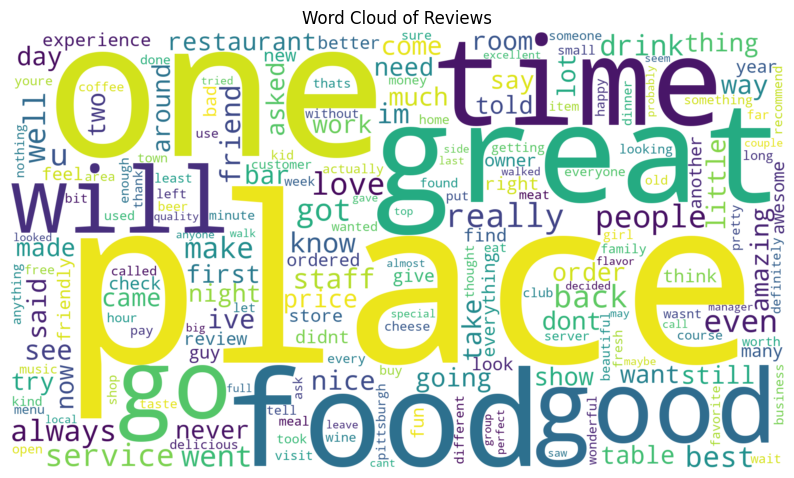

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all words into a single string
text_string = ' '.join(all_words)

# word cloud
wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text_string)

# Displaying the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Reviews")
plt.show()


In [8]:
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # all the stop words in english

# fun to remove stop words from text
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stop_words] # returing only those words which are not in stop_words(list of english stop words)

df['tokens'] = df['cleaned_review'].apply(remove_stop) # applying fun to each row and storing result in new column
print(df.head())

                                              review  class  \
0  Fantastic spot for an even or a quite cocktail...      1   
1  Love, love, love the calamari. It's so good an...      1   
2  Love this place. Stiff martinis and cocktails,...      1   
3  It's everything a great cocktail bar should be...      1   
4  I came here before a pirates game, so it was a...      1   

                                      cleaned_review  \
0  [fantastic, spot, for, an, even, or, a, quite,...   
1  [love, love, love, the, calamari, its, so, goo...   
2  [love, this, place, stiff, martinis, and, cock...   
3  [its, everything, a, great, cocktail, bar, sho...   
4  [i, came, here, before, a, pirates, game, so, ...   

                                              tokens  
0  [fantastic, spot, even, quite, cocktail, swell...  
1  [love, love, love, calamari, good, spicy, endl...  
2  [love, place, stiff, martinis, cocktails, chea...  
3  [everything, great, cocktail, bar, great, loca...  
4  [came,

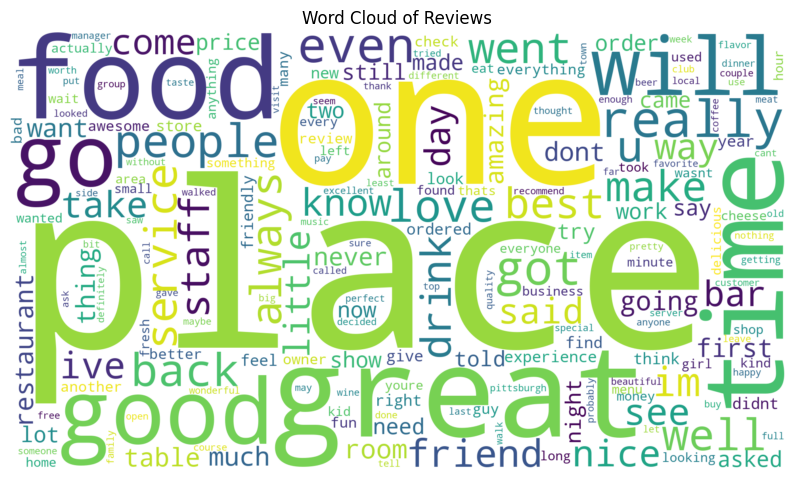

In [9]:
# word cloud of words without stop words
noStop_words = []
for words in df['tokens']:
    noStop_words.extend(words)

text_string = ' '.join(all_words)

wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text_string)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Reviews")
plt.show()

# Task 3: TF-IDF Analysis

In [10]:
from collections import Counter

counter = Counter() # intializing the counter obeject
df['tokens'].map(counter.update) # counting each token of each row in DF
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq']) # converting counter obeject to DataFrame
freq_df = freq_df.query('freq >= 1') # getting token whole value is 1 or higher
freq_df.index.name = 'token' 
freq_df = freq_df.sort_values('freq', ascending=False) # sorting the DF in descending order
freq_df.head(10)

,freq
token,
place,2685
great,1854
like,1849
one,1793
get,1690
time,1673
good,1468
go,1455
food,1419


In [11]:
import numpy as np

# fun to computer idf
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    # count tokens
    counter = Counter()
    df[column].map(update) # counting the tokens 
    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df') # removing tokens that are min than min_df(default 1)
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1 # idf
    idf_df.index.name = 'token'
    return idf_df

idf_df = compute_idf(df)

In [12]:
# calculating tf-idf
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()
freq_df['tfidf'].nlargest(5)  # top 5 TF-IDF words 

token
place    2718.507306
like     2479.774564
one      2430.698397
great    2383.975393
get      2366.875468
Name: tfidf, dtype: float64

In [13]:
# top 5 words
from collections import Counter

all_words = [] # to store data for word containg stop words
all_noStop_words = [] # to store data for word without stop words

# getting all the words and storing in list
for words in df['cleaned_review']:
    all_words.extend(words)

# getting all the words without stopwords and storing in list
for words in df['tokens']:
    all_noStop_words.extend(words)

# counting all words
word_counts = Counter(all_words)
print(f" Top 5 most appeaaring words: {word_counts.most_common(5)}")

word_counts1 = Counter(all_noStop_words)
print(f" Top 5 most appeaaring words without stop words: \n{word_counts1.most_common(5)}")

 Top 5 most appeaaring words: [('the', 25929), ('and', 18487), ('to', 14495), ('a', 14111), ('i', 14100)]
 Top 5 most appeaaring words without stop words: 
[('place', 2685), ('great', 1854), ('like', 1849), ('one', 1793), ('get', 1690)]


# Task 4: Review Length & Average Word Length

In [14]:
# counting avg words of each row
words_len = [] # list for storing the total lenght of a single row text
words_len_noStop = [] # list for storing the total lenght of a single row text of word without stopwords

"""
Note: i have displayed the total number of words letter in the code.
"""
# fun to count avg len of a single review
def avg_count(text):
    for word in text:
        words_len.append(len(word))
    return np.mean(words_len)

# fun to count avg of a single review text without stopwords
def avg_count1(text):
    for word in text:
        words_len_noStop.append(len(word))
    return np.mean(words_len_noStop)

# applying the fun
df['avg_len'] = df['cleaned_review'].apply(avg_count)
df['avg_len_nostopwords'] = df['tokens'].apply(avg_count1)

In [15]:
df.head(20)

,review,class,cleaned_review,tokens,avg_len,avg_len_nostopwords
0,Fantastic spot for an even or a quite cocktail...,1,"[fantastic, spot, for, an, even, or, a, quite,...","[fantastic, spot, even, quite, cocktail, swell...",4.475000,5.909091
1,"Love, love, love the calamari. It's so good an...",1,"[love, love, love, the, calamari, its, so, goo...","[love, love, love, calamari, good, spicy, endl...",4.135417,5.659574
2,"Love this place. Stiff martinis and cocktails,...",1,"[love, this, place, stiff, martinis, and, cock...","[love, place, stiff, martinis, cocktails, chea...",4.350318,5.707317
3,It's everything a great cocktail bar should be...,1,"[its, everything, a, great, cocktail, bar, sho...","[everything, great, cocktail, bar, great, loca...",4.396313,5.826087
4,"I came here before a pirates game, so it was a...",1,"[i, came, here, before, a, pirates, game, so, ...","[came, pirates, game, around, 530ish, evening,...",4.277473,5.681081
5,Olive or Twist is the historic site of my VERY...,1,"[olive, or, twist, is, the, historic, site, of...","[olive, twist, historic, site, first, martini,...",4.235131,5.723757
6,"A beautiful little bar with an exciting ""marti...",1,"[a, beautiful, little, bar, with, an, exciting...","[beautiful, little, bar, exciting, martini, li...",4.242953,5.718085
7,My favorite bar in town love the live music an...,1,"[my, favorite, bar, in, town, love, the, live,...","[favorite, bar, town, love, live, music, marti...",4.249344,5.722798
8,"The location is in a strip mall, but this plac...",1,"[the, location, is, in, a, strip, mall, but, t...","[location, strip, mall, place, diamond, rough,...",4.182456,5.675294
9,THIS PLACE IS OPEN!The best food and the best ...,1,"[this, place, is, openthe, best, food, and, th...","[place, openthe, best, food, best, service, tr...",4.192661,5.668192


In [16]:
"""
I used this code to verify my previous logic.
"""
word = df['cleaned_review'][0]
l = []
for w in word:
    l.append(len(w))
print(np.mean(l))
word1 = df['tokens'][0]
l = []
for w in word1:
    l.append(len(w))
np.mean(l)

4.475


5.909090909090909

# Task 5: Visualization

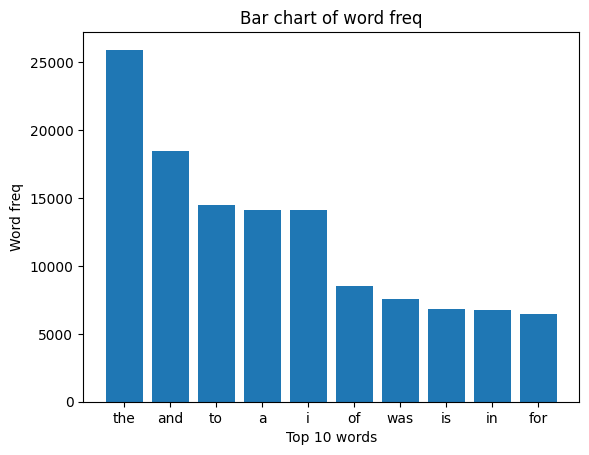

In [17]:
# using matplotlib to display word frequency of every top 10 words
import matplotlib.pyplot as plt

top10 = dict(word_counts.most_common(10)) # getting top 10 words from my previous list and converting into a dictionary
theWord = top10.keys() # getting all the words
wordFrq = top10.values() # getting freq values of each word

plt.bar(theWord, wordFrq) # bar chart
plt.xlabel("Top 10 words")
plt.ylabel("Word freq")
plt.title("Bar chart of word freq")
plt.show()

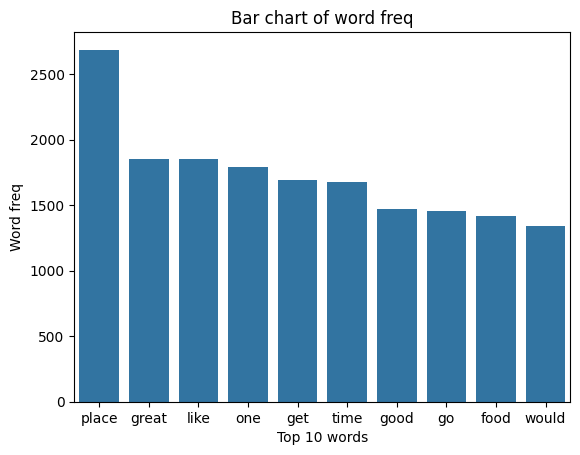

In [18]:
# using seaborn to display bar chart of word freq containg words without stopwords
import seaborn as sns

top10_words = dict(word_counts1.most_common(10))
newDf = pd.DataFrame.from_dict(top10_words, orient='index').reset_index() # converting the dictionary to padas DF
newDf.columns = ['word', 'freq'] # naming the columns 

sns.barplot(x='word', y='freq', data=newDf) # bar chart
plt.xlabel("Top 10 words")
plt.ylabel("Word freq")
plt.title("Bar chart of word freq")
plt.show()

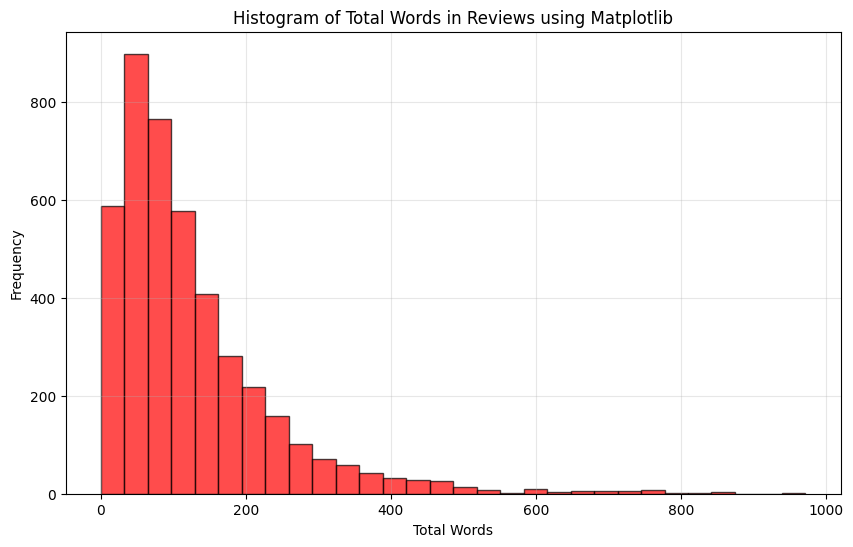

In [19]:
df['total_words'] = df['cleaned_review'].str.len() # counting each words in each review and storing into a new column

plt.figure(figsize=(10, 6))
plt.hist(df['total_words'], bins=30, edgecolor='black', color='red', alpha=0.7)
plt.xlabel('Total Words')
plt.ylabel('Frequency')
plt.title('Histogram of Total Words in Reviews using Matplotlib')
plt.grid(True, alpha=0.3)
plt.show()

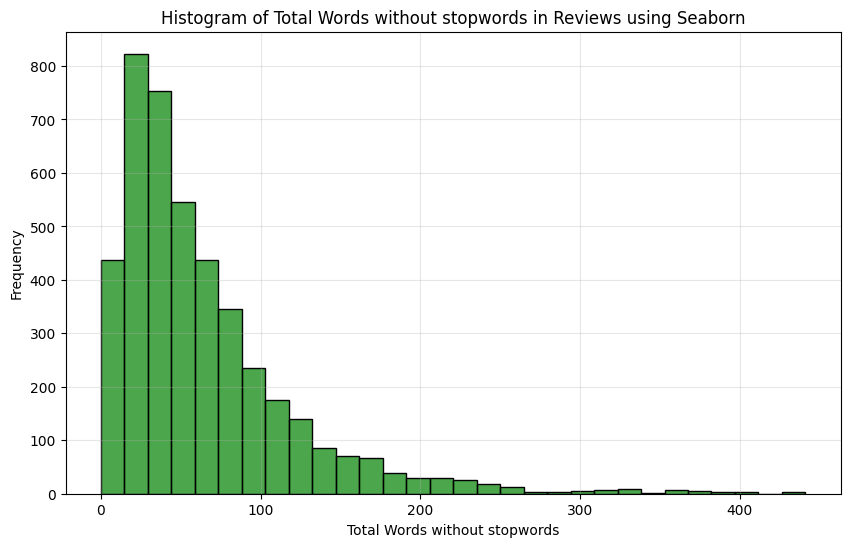

In [20]:
df['total_words_noStop'] = df['tokens'].str.len() # counting each words in token(containg words without stopwords)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='total_words_noStop', bins=30, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Total Words without stopwords')
plt.ylabel('Frequency')
plt.title('Histogram of Total Words without stopwords in Reviews using Seaborn')
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
df.head(20)

,review,class,cleaned_review,tokens,avg_len,avg_len_nostopwords,total_words,total_words_noStop
0,Fantastic spot for an even or a quite cocktail...,1,"[fantastic, spot, for, an, even, or, a, quite,...","[fantastic, spot, even, quite, cocktail, swell...",4.475000,5.909091,40,22
1,"Love, love, love the calamari. It's so good an...",1,"[love, love, love, the, calamari, its, so, goo...","[love, love, love, calamari, good, spicy, endl...",4.135417,5.659574,56,25
2,"Love this place. Stiff martinis and cocktails,...",1,"[love, this, place, stiff, martinis, and, cock...","[love, place, stiff, martinis, cocktails, chea...",4.350318,5.707317,61,35
3,It's everything a great cocktail bar should be...,1,"[its, everything, a, great, cocktail, bar, sho...","[everything, great, cocktail, bar, great, loca...",4.396313,5.826087,60,33
4,"I came here before a pirates game, so it was a...",1,"[i, came, here, before, a, pirates, game, so, ...","[came, pirates, game, around, 530ish, evening,...",4.277473,5.681081,147,70
5,Olive or Twist is the historic site of my VERY...,1,"[olive, or, twist, is, the, historic, site, of...","[olive, twist, historic, site, first, martini,...",4.235131,5.723757,359,177
6,"A beautiful little bar with an exciting ""marti...",1,"[a, beautiful, little, bar, with, an, exciting...","[beautiful, little, bar, exciting, martini, li...",4.242953,5.718085,22,14
7,My favorite bar in town love the live music an...,1,"[my, favorite, bar, in, town, love, the, live,...","[favorite, bar, town, love, live, music, marti...",4.249344,5.722798,17,10
8,"The location is in a strip mall, but this plac...",1,"[the, location, is, in, a, strip, mall, but, t...","[location, strip, mall, place, diamond, rough,...",4.182456,5.675294,93,39
9,THIS PLACE IS OPEN!The best food and the best ...,1,"[this, place, is, openthe, best, food, and, th...","[place, openthe, best, food, best, service, tr...",4.192661,5.668192,17,12


In [ ]:
"""
The dataset conatins the reviews for sentiment analysis. firstly after preprocessing the data and getting the tokens it
seems like the reviews conatains many many stop words which i found in counting all the words and comparing with removing
the stop words, i can see that top 5 review are stop words and they appere more than 15k times in the data while words
without stop words are the real data and the top 5 words in that are only apperes like aroud 2k times. Thus, removing stopwords
might save a lot of computational time and resources for the model train. But we need to be careful as in some scenario 
we might want to kepp not all but some stop words. as for the chart the bar chart displays the freq of words and we can see
bar chart of all words containing the stop word, most of the top 10 words are stop words and the range of all of them if
fluctuating. while in the second bar chart which containg words without stop words has a steady decilne in frequency. The 
Histograms are more or less the same in words having stopwords and not having stop words. Lastly, i have displayed the DF,
we can see that almost every review has around 40-60 % stop words. we should remove them acoording to the model we are 
making.
"""